# Benshi.ai Modeling Test - Contraceptives
---

## Preamble

In [1]:
# Standard Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px

# Import Files
from google.colab import drive
drive.mount('/drive')

#Linear Regression
from sklearn.linear_model import LinearRegression

# XGBoost
import xgboost as xgb
from xgboost import plot_importance, plot_tree

# CatBoost
!pip install catboost
import catboost


# Set Display Options
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 400

Mounted at /drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


## Data Preparation

In [2]:
# Tables Dictionary
dictionary_df = pd.read_csv('/drive/My Drive/Colab Notebooks/benshi modeling test/data_dictionary.csv')

# Training Data
contraceptive_logistics_df = pd.read_csv('/drive/My Drive/Colab Notebooks/benshi modeling test/Train.csv')
contraceptive_annual_df = pd.read_csv('/drive/My Drive/Colab Notebooks/benshi modeling test/contraceptive_case_data_annual.csv')
contraceptive_monthly_df = pd.read_csv('/drive/My Drive/Colab Notebooks/benshi modeling test/monthly_cases.csv')
service_df = pd.read_csv('/drive/My Drive/Colab Notebooks/benshi modeling test/service_delivery_site_data.csv')
product_df = pd.read_csv('/drive/My Drive/Colab Notebooks/benshi modeling test/product.csv')

# Submission Data
submission_df = pd.read_csv('/drive/My Drive/Colab Notebooks/benshi modeling test/SampleSubmission.csv')

dictionary_df

,File,Field,Description
0,contraceptive_logistics_data.csv,year,The year of the observation
1,contraceptive_logistics_data.csv,month,The month of the observation
2,contraceptive_logistics_data.csv,region,The higher level geographical area within Côte d’Ivoire
3,contraceptive_logistics_data.csv,district,The lower level geographical area within Côte d’Ivoire
4,contraceptive_logistics_data.csv,site_code,The actual health service delivery site
5,contraceptive_logistics_data.csv,product_code,The unique identifier for each commodity
6,contraceptive_logistics_data.csv,stock_initial,Stock in hand of previous period. This is quantified in dispensing units.
7,contraceptive_logistics_data.csv,stock_received,Total quantity received in last period. This is quantified in dispensing units.
8,contraceptive_logistics_data.csv,stock_distributed*,Quantity dispensed/consumed in last reporting period. This is quantified in dispensing units. Note: This is the target variable.
9,contraceptive_logistics_data.csv,stock_adjustment,All kinds of losses/ adjustments made at the facility


In [3]:
# Preprocess All the DataFrames

# contraceptive_logistics_df
contraceptive_logistics_df['year_month'] = pd.to_datetime(contraceptive_logistics_df[['year', 'month']].astype('str').agg('-'.join, axis=1), format='%Y-%m')

# submission_df
submission_df[['year', 'month', 'site_code', 'product_code']] = submission_df['ID'].str.split(' X ', expand=True)
submission_df['year_month'] = pd.to_datetime(submission_df[['year', 'month']].astype('str').agg('-'.join, axis=1), format='%Y-%m')

# contraceptive_annual_df
cols = contraceptive_annual_df.columns[~contraceptive_annual_df.columns.isin(['district','year'])]
contraceptive_annual_df.rename(columns = dict(zip(cols, cols + '_annual')), inplace=True)

# contraceptive_monthly_df
cols = contraceptive_monthly_df.columns[~contraceptive_monthly_df.columns.isin(['district','year', 'month'])]
contraceptive_monthly_df.rename(columns = dict(zip(cols, cols + '_monthly')), inplace=True)

# service_df
service_df.rename({'site_district':'district', 'site_region':'region'}, inplace=True)

In [4]:
# Create Base Table as a Base to Combine Everything

site_code = submission_df.site_code.unique()
product_code = submission_df.product_code.unique()
year_month = list(contraceptive_logistics_df.year_month.unique()) + list(submission_df.year_month.unique())

# Similar to how CROSS JOIN in SQL works, it will create all combinations of "year_month", "site_code", and "product_code" to ensure we can capture all the missing rows

index = pd.MultiIndex.from_product([year_month, site_code, product_code], names = ["year_month", "site_code", "product_code"])

base_df = pd.DataFrame(index = index).reset_index()

# Get "year" and "month" for joining purpose

base_df['year'] = base_df.year_month.dt.year
base_df['month'] = base_df.year_month.dt.month

base_df.sort_values(['site_code', 'product_code', 'year_month'], inplace=True)

base_df

,year_month,site_code,product_code,year,month
51379,2016-01-01,C1004,AS17005,2016,1
70134,2016-02-01,C1004,AS17005,2016,2
53084,2016-03-01,C1004,AS17005,2016,3
54789,2016-04-01,C1004,AS17005,2016,4
59904,2016-05-01,C1004,AS17005,2016,5
...,...,...,...,...,...
8522,2019-05-01,C5076,AS46000,2019,5
10227,2019-06-01,C5076,AS46000,2019,6
73312,2019-07-01,C5076,AS46000,2019,7
75017,2019-08-01,C5076,AS46000,2019,8


In [5]:
# Merge all the Data to the Base Table

merged_df = pd.merge(base_df, service_df, left_on = 'site_code', right_on = 'site_code', how='left') # Join with Service DF

merged_df = pd.merge(merged_df, product_df, left_on = 'product_code', right_on = 'product_code', how='left') # Join with Product DF

merged_df = pd.merge(merged_df, contraceptive_logistics_df.drop(['year', 'month'], axis=1), left_on = ['year_month', 'site_code', 'product_code'], right_on = ['year_month', 'site_code', 'product_code'], how='left') # Join with Main DF

merged_df = pd.merge(merged_df, contraceptive_monthly_df, left_on=['year', 'month', 'district'], right_on=['year', 'month', 'district'], how='left') # Join with Secondary DF (Monthly)

merged_df = pd.merge(merged_df, contraceptive_annual_df, left_on=['year', 'district'], right_on=['year', 'district'], how='left') # Join with Secondary DF (Annual)

merged_df.sort_values(['site_code', 'product_code', 'year_month'], ascending=True, inplace=True)

merged_df.drop(['region', 'district'], axis=1, inplace=True) # Drop Redundant Rows

merged_df.head(2)

,year_month,site_code,product_code,year,month,site_type,site_region,site_district,site_latitude,site_longitude,product_type,product_name,stock_initial,stock_received,stock_distributed,stock_adjustment,stock_end,average_monthly_consumption,stock_stockout_days,stock_ordered,implant_women_old_monthly,implant_women_new_monthly,injection2_women_old_monthly,injection2_women_new_monthly,injection3_women_old_monthly,injection3_women_new_monthly,pill_women_old_monthly,pill_women_new_monthly,iud_women_old_monthly,iud_women_new_monthly,iud_number_dispensed_monthly,implant_number_dispensed_monthly,injection2_number_dispensed_monthly,injection3_number_dispensed_monthly,pill_number_dispensed_monthly,iud_number_received_monthly,implant_number_received_monthly,injection2_number_received_monthly,injection3_number_received_monthly,pill_number_received_monthly,iud_stock_end_monthly,implant_stock_end_monthly,injection2_stock_end_monthly,injection3_stock_end_monthly,pill_stock_end_monthly,implant_women_old_annual,implant_women_new_annual,injection2_women_old_annual,injection2_women_new_annual,injection3_women_old_annual,injection3_women_new_annual,pill_women_old_annual,pill_women_new_annual,iud_women_old_annual,iud_women_new_annual,iud_number_dispensed_annual,implant_number_dispensed_annual,injection2_number_dispensed_annual,injection3_number_dispensed_annual,pill_number_dispensed_annual,iud_number_received_annual,implant_number_received_annual,injection2_number_received_annual,injection3_number_received_annual,pill_number_received_annual,iud_stock_end_annual,implant_stock_end_annual,injection2_stock_end_annual,injection3_stock_end_annual,pill_stock_end_annual
0,2016-01-01,C1004,AS17005,2016,1,Hospital,AGNEBY-TIASSA-ME,AGBOVILLE,5.92834,-4.21145,Female Condom,PRESERVATIF FEMININ UNITE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-02-01,C1004,AS17005,2016,2,Hospital,AGNEBY-TIASSA-ME,AGBOVILLE,5.92834,-4.21145,Female Condom,PRESERVATIF FEMININ UNITE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Exploration

In [64]:
#stock_distributed

# sku sales performance
fig = px.line(merged_df.groupby('year_month').agg(stock_distributed=('stock_distributed', 'sum')).reset_index(), x="year_month", y="stock_distributed", title='Stock Distributed (Qty)')
fig.show()

In [6]:
# Show sample 'product_code' (Pill) on a site_code with all its possible relevant existing features

merged_df.loc[(merged_df['site_code']=='C1004') & (merged_df['product_code']=='AS27000')][['year_month', 'product_type', 'stock_distributed', 'pill_women_old_monthly', 'pill_women_new_monthly', 
                                                                                            'pill_number_dispensed_monthly', 'pill_number_received_monthly', 'pill_stock_end_monthly',
                                                                                            'pill_number_dispensed_annual', 'pill_number_received_annual', 'pill_stock_end_annual']]

,year_month,product_type,stock_distributed,pill_women_old_monthly,pill_women_new_monthly,pill_number_dispensed_monthly,pill_number_received_monthly,pill_stock_end_monthly,pill_number_dispensed_annual,pill_number_received_annual,pill_stock_end_annual
90,2016-01-01,Oral Contraceptive (Pill),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,2016-02-01,Oral Contraceptive (Pill),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,2016-03-01,Oral Contraceptive (Pill),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,2016-04-01,Oral Contraceptive (Pill),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
94,2016-05-01,Oral Contraceptive (Pill),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,2016-06-01,Oral Contraceptive (Pill),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,2016-07-01,Oral Contraceptive (Pill),0.0,NaN,NaN,NaN,NaN,NaN,4780.0,7440.0,NaN
97,2016-08-01,Oral Contraceptive (Pill),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,2016-09-01,Oral Contraceptive (Pill),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,2016-10-01,Oral Contraceptive (Pill),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#stock_distributed

# sku sales performance
fig = px.line(merged_df.loc[(merged_df['site_code']=='C1004') & (merged_df['product_code']=='AS27000')], x="year_month", y="stock_distributed", title='Stock Distributed (Qty)')
fig.show()

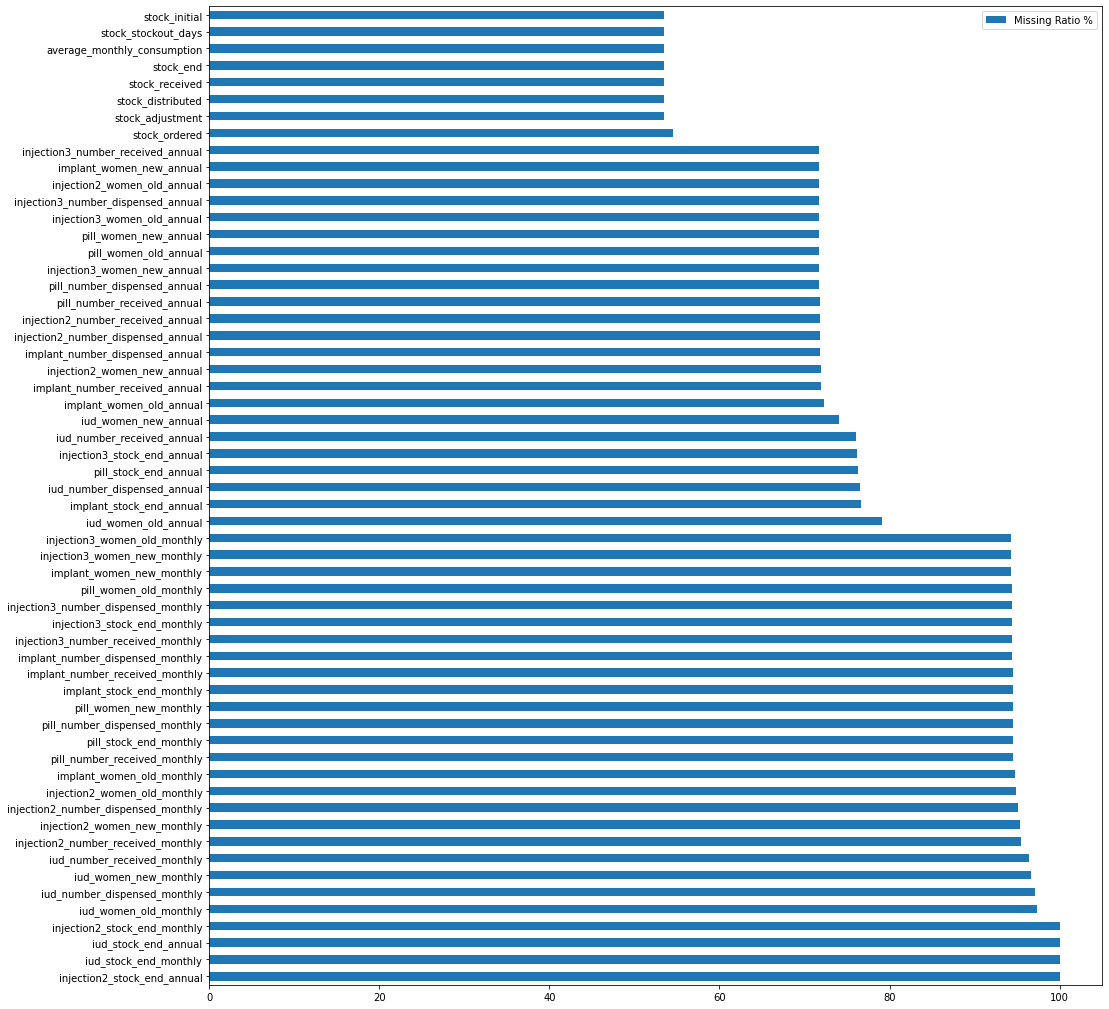

In [8]:
# Plot Missing Values

def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh", figsize=(16,18))
        plt.show()
    else:
        print('No NAs found')

plot_nas(merged_df)

## Feature Engineering

In [216]:
feature_df = merged_df.copy()

feature_df['year_month_str'] = feature_df.year_month.astype('str')

### Aggregated Feature

In [217]:
# Site Level Aggregation

site_df = feature_df.groupby(['site_code', 'year_month']).agg(
              stock_distributed_site_agg=('stock_distributed', np.nanmean)
              ).reset_index()

feature_df = pd.merge(feature_df, site_df, right_on=['site_code', 'year_month'], left_on=['site_code', 'year_month'], how='left')

# District Level Aggregation

district_df = feature_df.groupby(['site_district', 'year_month']).agg(
                stock_distributed_district_agg=('stock_distributed', np.nanmean)
                ).reset_index()

feature_df = pd.merge(feature_df, district_df, right_on=['site_district', 'year_month'], left_on=['site_district', 'year_month'], how='left')

# Region Level Aggregation

region_df = feature_df.groupby(['site_region', 'product_code', 'year_month']).agg(
                stock_distributed_region_agg=('stock_distributed', np.nanmean)
                ).reset_index()

feature_df = pd.merge(feature_df, region_df, right_on=['site_region', 'product_code', 'year_month'], left_on=['site_region', 'product_code', 'year_month'], how='left')

# Sanity Check

feature_df.loc[(feature_df['site_code']=='C1004') & (feature_df['product_code']=='AS27000')][['year_month', 'site_region', 'site_district', 'site_code', 'product_type', 'stock_distributed',
                                                                                              'stock_distributed_site_agg', 'stock_distributed_district_agg', 'stock_distributed_region_agg']].head(10)

,year_month,site_region,site_district,site_code,product_type,stock_distributed,stock_distributed_site_agg,stock_distributed_district_agg,stock_distributed_region_agg
90,2016-01-01,AGNEBY-TIASSA-ME,AGBOVILLE,C1004,Oral Contraceptive (Pill),NaN,NaN,NaN,6.250000
91,2016-02-01,AGNEBY-TIASSA-ME,AGBOVILLE,C1004,Oral Contraceptive (Pill),NaN,NaN,NaN,3.333333
92,2016-03-01,AGNEBY-TIASSA-ME,AGBOVILLE,C1004,Oral Contraceptive (Pill),NaN,NaN,NaN,27.000000
93,2016-04-01,AGNEBY-TIASSA-ME,AGBOVILLE,C1004,Oral Contraceptive (Pill),NaN,NaN,NaN,12.000000
94,2016-05-01,AGNEBY-TIASSA-ME,AGBOVILLE,C1004,Oral Contraceptive (Pill),NaN,NaN,NaN,13.333333
95,2016-06-01,AGNEBY-TIASSA-ME,AGBOVILLE,C1004,Oral Contraceptive (Pill),NaN,NaN,NaN,12.600000
96,2016-07-01,AGNEBY-TIASSA-ME,AGBOVILLE,C1004,Oral Contraceptive (Pill),0.0,0.0,0.0,10.285714
97,2016-08-01,AGNEBY-TIASSA-ME,AGBOVILLE,C1004,Oral Contraceptive (Pill),NaN,NaN,NaN,8.875000
98,2016-09-01,AGNEBY-TIASSA-ME,AGBOVILLE,C1004,Oral Contraceptive (Pill),NaN,NaN,NaN,24.375000
99,2016-10-01,AGNEBY-TIASSA-ME,AGBOVILLE,C1004,Oral Contraceptive (Pill),NaN,NaN,NaN,11.750000


### Lagging Feature

In [218]:
# Create Lag 1 and Lag 2 Features

feature_df.sort_values(['site_code', 'product_code', 'year_month'], ascending=True, inplace=True)

for i in range(1,3):
  feature_df['stock_distributed_monthlag'+'{}'.format(i)] = feature_df.groupby(['site_code', 'product_code'])['stock_distributed'].shift(i)
  feature_df['stock_distributed_site_agg_monthlag'+'{}'.format(i)] = feature_df.groupby(['site_code', 'product_code'])['stock_distributed_site_agg'].shift(i)
  feature_df['stock_distributed_district_agg_monthlag'+'{}'.format(i)] = feature_df.groupby(['site_code', 'product_code'])['stock_distributed_district_agg'].shift(i)
  feature_df['stock_distributed_region_agg_monthlag'+'{}'.format(i)] = feature_df.groupby(['site_code', 'product_code'])['stock_distributed_region_agg'].shift(i)

  feature_df['average_monthly_consumption_monthlag'+'{}'.format(i)] = feature_df.groupby(['site_code', 'product_code'])['stock_distributed_region_agg'].shift(i)
  feature_df['stock_end_monthlag'+'{}'.format(i)] = feature_df.groupby(['site_code', 'product_code'])['stock_distributed_region_agg'].shift(i)

feature_df.head()

,year_month,site_code,product_code,year,month,site_type,site_region,site_district,site_latitude,site_longitude,product_type,product_name,stock_initial,stock_received,stock_distributed,stock_adjustment,stock_end,average_monthly_consumption,stock_stockout_days,stock_ordered,implant_women_old_monthly,implant_women_new_monthly,injection2_women_old_monthly,injection2_women_new_monthly,injection3_women_old_monthly,injection3_women_new_monthly,pill_women_old_monthly,pill_women_new_monthly,iud_women_old_monthly,iud_women_new_monthly,iud_number_dispensed_monthly,implant_number_dispensed_monthly,injection2_number_dispensed_monthly,injection3_number_dispensed_monthly,pill_number_dispensed_monthly,iud_number_received_monthly,implant_number_received_monthly,injection2_number_received_monthly,injection3_number_received_monthly,pill_number_received_monthly,iud_stock_end_monthly,implant_stock_end_monthly,injection2_stock_end_monthly,injection3_stock_end_monthly,pill_stock_end_monthly,implant_women_old_annual,implant_women_new_annual,injection2_women_old_annual,injection2_women_new_annual,injection3_women_old_annual,injection3_women_new_annual,pill_women_old_annual,pill_women_new_annual,iud_women_old_annual,iud_women_new_annual,iud_number_dispensed_annual,implant_number_dispensed_annual,injection2_number_dispensed_annual,injection3_number_dispensed_annual,pill_number_dispensed_annual,iud_number_received_annual,implant_number_received_annual,injection2_number_received_annual,injection3_number_received_annual,pill_number_received_annual,iud_stock_end_annual,implant_stock_end_annual,injection2_stock_end_annual,injection3_stock_end_annual,pill_stock_end_annual,nonzero,year_month_str,stock_distributed_site_agg,stock_distributed_district_agg,stock_distributed_region_agg,stock_distributed_monthlag1,stock_distributed_site_agg_monthlag1,stock_distributed_district_agg_monthlag1,stock_distributed_region_agg_monthlag1,average_monthly_consumption_monthlag1,stock_end_monthlag1,stock_distributed_monthlag2,stock_distributed_site_agg_monthlag2,stock_distributed_district_agg_monthlag2,stock_distributed_region_agg_monthlag2,average_monthly_consumption_monthlag2,stock_end_monthlag2
0,2016-01-01,C1004,AS17005,2016,1,Hospital,AGNEBY-TIASSA-ME,AGBOVILLE,5.92834,-4.21145,Female Condom,PRESERVATIF FEMININ UNITE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2016-01-01,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-02-01,C1004,AS17005,2016,2,Hospital,AGNEBY-TIASSA-ME,AGBOVILLE,5.92834,-4.21145,Female Condom,PRESERVATIF FEMININ UNITE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2016-02-01,NaN,NaN,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-03-01,C1004,AS17005,2016,3,Hospital,AGNEBY-TIASSA-ME,AGBOVILLE,5.92834,-4.21145,Female Condom,PRESERVATIF FEMININ UNITE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2016-03-01,NaN,NaN,0.333333,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000
3,2016-04-01,C1004,AS17005,2016,4,Hospital,AGNEBY-TIASSA-ME,AGBOVILLE,5.92834,-4.21145,Female Condom,PRESERVATIF FEMININ UNITE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2016-04-01,NaN,NaN,0.333333,NaN,NaN,NaN,0.333333,0.333333,0.333333,NaN,NaN,NaN,0.000000,0.000000,0.

## Data Processing

In [219]:
TRAIN_START_MONTH = '2016-07-01' # Train Data Using Data 6 Months after the First Data Recorded
TRAIN_END_MONTH = '2019-04-01'

TEST_START_MONTH = '2019-05-01' # Test Data Using Last 2 Month Data
TEST_END_MONTH = '2019-06-01'

PREDICTION_START_MONTH = '2019-07-01' # Prediction Data Based on Submission Requirement
PREDICTION_END_MONTH = '2019-09-01'

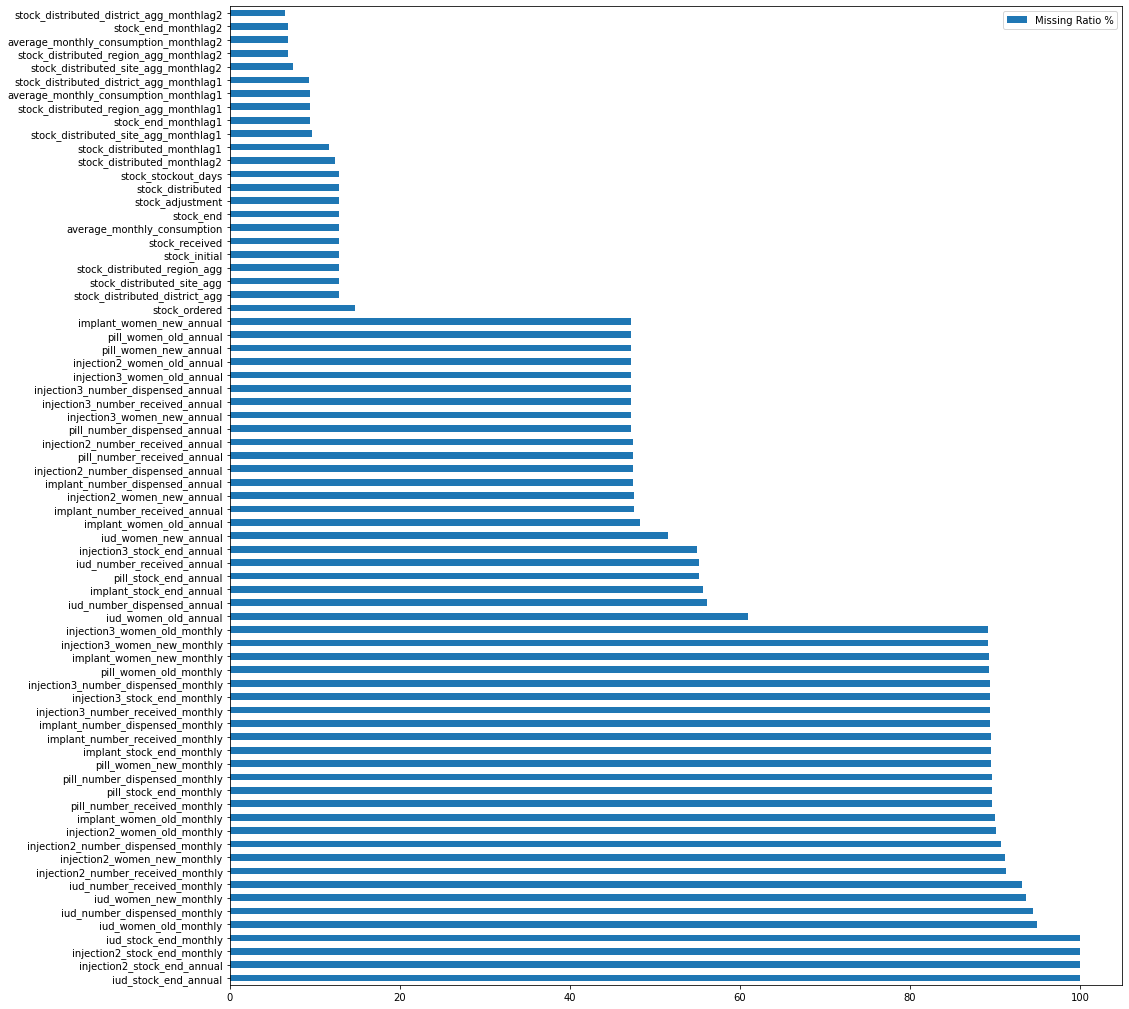

In [220]:
# Remove Rows where contraceptive distribution haven't started yet

feature_df.drop(feature_df[(feature_df.year_month < PREDICTION_START_MONTH) & (feature_df.stock_distributed.isna())].index, inplace=True)

# Remove Rows

feature_df.drop(feature_df[(feature_df.stock_distributed == 0) & (feature_df.stock_distributed_monthlag1.isna()) & (feature_df.stock_distributed_monthlag2.isna())].index, inplace=True)

# Check Null Values Again

plot_nas(feature_df)

In [221]:
# Treat Missing Values

# Forward Fill

feature_df.fillna(method='ffill', inplace=True)

feature_df.fillna(0, inplace=True)

# Sanity Check

feature_df.loc[(feature_df['site_code']=='C1004') & (feature_df['product_code']=='AS27000')][['year_month', 'site_region', 'site_district', 'site_code', 'product_type', 
                                                                                              'stock_distributed', 'stock_distributed_monthlag1', 'stock_distributed_monthlag2',
                                                                                              'stock_distributed_site_agg', 'stock_distributed_district_agg', 'stock_distributed_region_agg']].head(5)

,year_month,site_region,site_district,site_code,product_type,stock_distributed,stock_distributed_monthlag1,stock_distributed_monthlag2,stock_distributed_site_agg,stock_distributed_district_agg,stock_distributed_region_agg
109,2017-08-01,AGNEBY-TIASSA-ME,AGBOVILLE,C1004,Oral Contraceptive (Pill),7.0,0.0,0.0,3.400000,3.400000,14.777778
110,2017-09-01,AGNEBY-TIASSA-ME,AGBOVILLE,C1004,Oral Contraceptive (Pill),44.0,7.0,0.0,45.500000,45.500000,14.888889
111,2017-10-01,AGNEBY-TIASSA-ME,AGBOVILLE,C1004,Oral Contraceptive (Pill),13.0,44.0,7.0,9.000000,9.000000,12.777778
112,2017-11-01,AGNEBY-TIASSA-ME,AGBOVILLE,C1004,Oral Contraceptive (Pill),16.0,13.0,44.0,16.000000,16.000000,8.888889
113,2017-12-01,AGNEBY-TIASSA-ME,AGBOVILLE,C1004,Oral Contraceptive (Pill),32.0,16.0,13.0,20.666667,20.666667,7.444444


In [222]:
# Split Data

train_df = feature_df.query("year_month >= '{}' & year_month <= '{}'".format(TRAIN_START_MONTH,TRAIN_END_MONTH)).copy()
test_df = feature_df.query("year_month >= '{}' & year_month <= '{}'".format(TEST_START_MONTH,TEST_END_MONTH)).copy()
pred_df = feature_df.query("year_month >= '{}' & year_month <= '{}'".format(PREDICTION_START_MONTH,PREDICTION_END_MONTH)).copy()

## Modeling

### 0. Baseline (Linear Regression)

In [223]:
# Feature Selection

linreg_features = ['stock_distributed_monthlag1', 'stock_distributed_monthlag2',
                  ]

target = ['stock_distributed']

X_train = train_df[linreg_features]
y_train = train_df[target]

X_test = test_df[linreg_features]
y_test = test_df[target]


In [224]:
reg = LinearRegression()

reg.fit(X_train, y_train)

LinearRegression()

In [225]:
# Create Prediction

test_df['linreg_prediction'] = reg.predict(X_test)
test_df['linreg_prediction'] = test_df.linreg_prediction.apply(lambda x: 0 if x < 0 else x) # fix minus value
test_df['linreg_prediction'] = test_df.linreg_prediction.round() # round value

test_df[['year_month', 'site_code', 'product_code', 'stock_distributed', 'linreg_prediction']].head()

,year_month,site_code,product_code,stock_distributed,linreg_prediction
85,2019-05-01,C1004,AS21126,0.0,6.0
130,2019-05-01,C1004,AS27000,30.0,26.0
131,2019-06-01,C1004,AS27000,21.0,28.0
175,2019-05-01,C1004,AS27132,2.0,6.0
176,2019-06-01,C1004,AS27132,1.0,6.0


### 1. XGBoost

In [239]:
# Feature Selection

xgb_features = ['stock_distributed_monthlag1', 'stock_distributed_monthlag2',
                'stock_distributed_site_agg_monthlag1', 'stock_distributed_site_agg_monthlag2',
                'stock_distributed_district_agg_monthlag1', 'stock_distributed_district_agg_monthlag2',
                'stock_distributed_region_agg_monthlag1', 'stock_distributed_region_agg_monthlag2',
                'average_monthly_consumption_monthlag1', 'average_monthly_consumption_monthlag2',
                'stock_end_monthlag1', 'stock_end_monthlag2',
                ]

target = ['stock_distributed']

X_train = train_df[xgb_features]
y_train = train_df[target]

X_test = test_df[xgb_features]
y_test = test_df[target]



In [227]:
from sklearn.model_selection import RandomizedSearchCV

#xgboost = xgb.XGBRegressor(n_estimators=1000, eval_metric='mae')


params = {
 "learning_rate" : [0.05,0.10,0.20,0.25],
 "max_depth" : [ 3, 5, 10, 15],
 "gamma": [ 0.0, 0.1, 0.2 , 0.4 ],
}

xgboost = RandomizedSearchCV(xgb.XGBRegressor(eval_metric='mae'),param_distributions=params,n_iter=5,cv=5)
xgboost.fit(X_train, y_train, verbose=False) 

[15:40:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:40:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:41:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

RandomizedSearchCV(cv=5, estimator=XGBRegressor(eval_metric='mae'), n_iter=5,
                   param_distributions={'gamma': [0.0, 0.1, 0.2, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.2, 0.25],
                                        'max_depth': [3, 5, 10, 15]})

In [240]:
# Create Prediction

test_df['xgboost_prediction'] = xgboost.predict(X_test)
test_df['xgboost_prediction'] = test_df.xgboost_prediction.apply(lambda x: 0 if x < 0 else x) # fix minus value
test_df['xgboost_prediction'] = test_df.xgboost_prediction.round() # round value

test_df.head()

,year_month,site_code,product_code,year,month,site_type,site_region,site_district,site_latitude,site_longitude,product_type,product_name,stock_initial,stock_received,stock_distributed,stock_adjustment,stock_end,average_monthly_consumption,stock_stockout_days,stock_ordered,implant_women_old_monthly,implant_women_new_monthly,injection2_women_old_monthly,injection2_women_new_monthly,injection3_women_old_monthly,injection3_women_new_monthly,pill_women_old_monthly,pill_women_new_monthly,iud_women_old_monthly,iud_women_new_monthly,iud_number_dispensed_monthly,implant_number_dispensed_monthly,injection2_number_dispensed_monthly,injection3_number_dispensed_monthly,pill_number_dispensed_monthly,iud_number_received_monthly,implant_number_received_monthly,injection2_number_received_monthly,injection3_number_received_monthly,pill_number_received_monthly,iud_stock_end_monthly,implant_stock_end_monthly,injection2_stock_end_monthly,injection3_stock_end_monthly,pill_stock_end_monthly,implant_women_old_annual,implant_women_new_annual,injection2_women_old_annual,injection2_women_new_annual,injection3_women_old_annual,...,pill_women_new_annual,iud_women_old_annual,iud_women_new_annual,iud_number_dispensed_annual,implant_number_dispensed_annual,injection2_number_dispensed_annual,injection3_number_dispensed_annual,pill_number_dispensed_annual,iud_number_received_annual,implant_number_received_annual,injection2_number_received_annual,injection3_number_received_annual,pill_number_received_annual,iud_stock_end_annual,implant_stock_end_annual,injection2_stock_end_annual,injection3_stock_end_annual,pill_stock_end_annual,nonzero,year_month_str,stock_distributed_site_agg,stock_distributed_district_agg,stock_distributed_region_agg,stock_distributed_monthlag1,stock_distributed_site_agg_monthlag1,stock_distributed_district_agg_monthlag1,stock_distributed_region_agg_monthlag1,average_monthly_consumption_monthlag1,stock_end_monthlag1,stock_distributed_monthlag2,stock_distributed_site_agg_monthlag2,stock_distributed_district_agg_monthlag2,stock_distributed_region_agg_monthlag2,average_monthly_consumption_monthlag2,stock_end_monthlag2,linreg_prediction,xgboost_prediction,catboost_prediction,precision_band_30 linreg_prediction,precision_band_50 linreg_prediction,mape linreg_prediction,mape_distribution linreg_prediction,precision_band_30 xgboost_prediction,precision_band_50 xgboost_prediction,mape xgboost_prediction,mape_distribution xgboost_prediction,precision_band_30 catboost_prediction,precision_band_50 catboost_prediction,mape catboost_prediction,mape_distribution catboost_prediction
130,2019-05-01,C1004,AS27000,2019,5,Hospital,AGNEBY-TIASSA-ME,AGBOVILLE,5.92834,-4.21145,Oral Contraceptive (Pill),MICROGYNON 0.03/0.15 MG BTE / 3 CYCLES BOITE,0.0,51.0,30.0,0.0,21.0,31.0,0.0,72.0,375.0,62.0,15.0,2.0,937.0,124.0,64.0,54.0,63.0,1.0,5.0,126.0,19.0,979.0,323.0,11.0,142.0,87.0,1055.0,666.0,0.0,313.0,0.0,673.0,581.0,2591.0,1025.0,1444.0,312.0,8395.0,...,276.0,593.0,236.0,208.0,958.0,1707.0,8971.0,3945.0,562.0,1441.0,2769.0,10060.0,8478.0,0.0,1109.0,0.0,3547.0,5679.0,1,2019-05-01,16.5,16.5,17.181818,43.0,25.25,25.25,22.363636,22.363636,22.363636,19.0,3.666667,3.666667,12.636364,12.636364,12.636364,26.0,25.0,28.0,1,1,0.129032,None,1,1,0.161290,None,1,1,0.064516,None
131,2019-06-01,C1004,AS27000,2019,6,Hospital,AGNEBY-TIASSA-ME,AGBOVILLE,5.92834,-4.21145,Oral Contraceptive (Pill),MICROGYNON 0.03/0.15 MG BTE / 3 CYCLES BOITE,21.0,54.0,21.0,0.0,54.0,31.0,0.0,39.0,375.0,62.0,132.0,15.0,741.0,116.0,222.0,314.0,58.0,4.0,3.0,103.0,123.0,845.0,383.0,8.0,371.0,204.0,1144.0,644.0,0.0,320.0,0.0,447.0,576.0,2591.0,1025.0,1444.0,312.0,8395.0,...,276.0,593.0,236.0,208.0,958.0,1707.0,8971.0,3945.0,562.0,1441.0,2769.0,10060.0,8478.0,0.0,1109.0,0.0,3547.0,5679.0,1,2019-06-01,19.2,19.2,14.545455,30.0,16.50,16.50,17.181818,17.181818,17.181818,43.0,25.250000,25.250000,22.363636,22.363636,22.363636,28.0,32.0,37.0,1,1,0.318182,None,0,1,0.500000,None,0,1,0.727273,None
175,2019-05-01,C1004,A

### 2. CatBoost

In [229]:
# Feature Selection

cbr_features = ['year_month_str', 'site_region', 'site_district', 'site_code', 'product_type', 'product_code',
                'stock_distributed_monthlag1', 'stock_distributed_monthlag2',
                'stock_distributed_site_agg_monthlag1', 'stock_distributed_site_agg_monthlag2',
                'stock_distributed_district_agg_monthlag1', 'stock_distributed_district_agg_monthlag2',
                'stock_distributed_region_agg_monthlag1', 'stock_distributed_region_agg_monthlag2',
                'average_monthly_consumption_monthlag1', 'average_monthly_consumption_monthlag2',
                'stock_end_monthlag1', 'stock_end_monthlag2',
                ]

cbr_categories = ['year_month_str', 'site_region', 'site_district', 'site_code', 'product_type', 'product_code']

target = ['stock_distributed']

X_train = train_df[cbr_features]
y_train = train_df[target]

X_test = test_df[cbr_features]
y_test = test_df[target]



0:	learn: 0.7072279	test: 0.7058996	best: 0.7058996 (0)	total: 27ms	remaining: 6.71s
1:	learn: 0.8744012	test: 0.8675647	best: 0.7058996 (0)	total: 50.2ms	remaining: 6.22s
2:	learn: 1.0519238	test: 1.0431209	best: 0.7058996 (0)	total: 75.3ms	remaining: 6.2s
3:	learn: 1.2246147	test: 1.2098007	best: 0.7058996 (0)	total: 101ms	remaining: 6.22s
4:	learn: 1.4292281	test: 1.4132179	best: 0.7058996 (0)	total: 122ms	remaining: 5.97s
5:	learn: 1.5833172	test: 1.5658241	best: 0.7058996 (0)	total: 144ms	remaining: 5.87s
6:	learn: 1.7351135	test: 1.7117015	best: 0.7058996 (0)	total: 167ms	remaining: 5.81s
7:	learn: 1.8605357	test: 1.8336121	best: 0.7058996 (0)	total: 189ms	remaining: 5.73s
8:	learn: 2.0043197	test: 1.9773930	best: 0.7058996 (0)	total: 213ms	remaining: 5.7s
9:	learn: 2.1232906	test: 2.0930471	best: 0.7058996 (0)	total: 239ms	remaining: 5.74s
10:	learn: 2.2534156	test: 2.2178405	best: 0.7058996 (0)	total: 263ms	remaining: 5.71s
11:	learn: 2.3892739	test: 2.3504441	best: 0.7058996 (

Text(0.5, 1.0, 'Feature Importance')

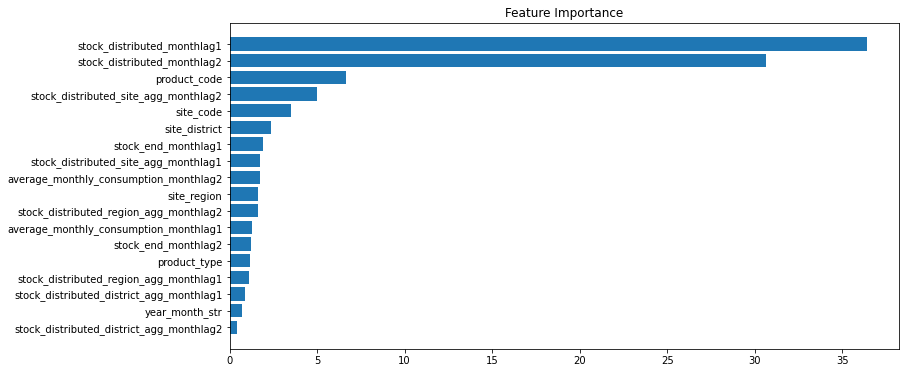

In [230]:
# Randomized Search CatBoost

cbr = catboost.CatBoostRegressor(eval_metric = 'MAPE', 
                                   cat_features=cbr_categories) # CatBoostRegressor
                           
param_grid = {'learning_rate': [0.03, 0.05, 0.1, 0.5],
              'depth': [2, 4, 6, 8, 10],
              'iterations'    : [250, 500, 750],
              'l2_leaf_reg': [1, 3, 5, 7, 9]}

cbr.randomized_search(param_grid, X_train, y_train, cv = 5, n_iter = 5, verbose=False)

# cbr.fit(X_train, y_train, verbose=False)

# Plot Feature Importance

feature_importance = cbr.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')


In [231]:
# Create Prediction

test_df['catboost_prediction'] = cbr.predict(X_test)
test_df['catboost_prediction'] = test_df.catboost_prediction.apply(lambda x: 0 if x < 0 else x) # fix minus value
test_df['catboost_prediction'] = test_df.catboost_prediction.round() # round value

test_df[['year_month', 'site_code', 'product_code', 'stock_distributed', 'catboost_prediction']].head()

,year_month,site_code,product_code,stock_distributed,catboost_prediction
85,2019-05-01,C1004,AS21126,0.0,4.0
130,2019-05-01,C1004,AS27000,30.0,28.0
131,2019-06-01,C1004,AS27000,21.0,37.0
175,2019-05-01,C1004,AS27132,2.0,5.0
176,2019-06-01,C1004,AS27132,1.0,5.0


## Evaluation

In [232]:
def in_precision_band(df, y_true, y_pred, precision_band):
  def precision_band_calc(y_true, y_pred, precision_band):
    if (y_true>=(y_pred*(1-precision_band/100))) & (y_true <= (y_pred*(1+precision_band/100))):
      return 1
    else:
      return 0
  df['precision_band_{} {}'.format(precision_band, y_pred)] = df.apply(lambda x: precision_band_calc(x[y_true], x[y_pred], precision_band), axis=1)

def create_mape_distribution(df, y_true, y_pred):
  def mape_distribution(y_true, y_pred):
      mape = np.abs(y_true-y_pred)/(y_true+1)

  df['mape {}'.format(y_pred)] = (df[y_true] - df[y_pred]).abs() / (df[y_true] + 1)
  df['mape_distribution {}'.format(y_pred)] = df.apply(lambda x: mape_distribution(x[y_true], x[y_pred]), axis=1)


# Run the Function

for pred in ['linreg_prediction', 'xgboost_prediction', 'catboost_prediction']:
  in_precision_band(test_df, 'stock_distributed', pred, 30)
  in_precision_band(test_df, 'stock_distributed', pred, 50)
  create_mape_distribution(test_df, 'stock_distributed', pred)

In [233]:
# Remove entries where Stock End is 0 and Stock Distributed also 0 for less biased performance metrics

test_df.drop(test_df[(test_df.stock_end == 0) & (test_df.stock_distributed == 0)].index, inplace=True)

In [234]:
# Print Model Performance

print('Model Performance:')
print('---------------------------------------------------------')

print("LinReg   |   MAPE={mape}    |   PB30={pb30}   |   PB50={pb50}".format(
    mape=np.round(np.mean(test_df['mape linreg_prediction']),2), 
    pb30=np.round(np.mean(test_df['precision_band_30 linreg_prediction']),2),
    pb50=np.round(np.mean(test_df['precision_band_50 linreg_prediction']),2)
))

print("XGBoost  |   MAPE={mape}    |   PB30={pb30}   |   PB50={pb50}".format(
    mape=np.round(np.mean(test_df['mape xgboost_prediction']),2), 
    pb30=np.round(np.mean(test_df['precision_band_30 xgboost_prediction']),2),
    pb50=np.round(np.mean(test_df['precision_band_50 xgboost_prediction']),2)
))

print("CatBoost |   MAPE={mape}    |   PB30={pb30}   |   PB50={pb50}".format(
    mape=np.round(np.mean(test_df['mape catboost_prediction']),2), 
    pb30=np.round(np.mean(test_df['precision_band_30 catboost_prediction']),2),
    pb50=np.round(np.mean(test_df['precision_band_50 catboost_prediction']),2)
))

Model Performance:
---------------------------------------------------------
LinReg   |   MAPE=2.93    |   PB30=0.24   |   PB50=0.41
XGBoost  |   MAPE=2.67    |   PB30=0.25   |   PB50=0.42
CatBoost |   MAPE=2.64    |   PB30=0.26   |   PB50=0.43


## Submission

In [241]:
# Predict for Submission

best_model = cbr

X_pred = pred_df[cbr_features]

pred_df['model_prediction'] = best_model.predict(X_pred)

# Arrange the Submission Data

submission_df['prediction'] = np.nan

final_submission_df = pd.merge(submission_df, pred_df, left_on = ['year_month', 'site_code', 'product_code'], right_on = ['year_month', 'site_code', 'product_code'], how='left')

final_submission_df['prediction'] = final_submission_df.model_prediction

final_submission_df = final_submission_df[['ID', 'prediction']]

final_submission_df.head()

,ID,prediction
0,2019 X 7 X C4001 X AS21126,3.819582
1,2019 X 7 X C4001 X AS27134,15.625965
2,2019 X 7 X C4001 X AS27132,3.758818
3,2019 X 7 X C4001 X AS27000,12.563527
4,2019 X 7 X C4001 X AS27137,3.643009


In [242]:
# Sanity Check NaNs

plot_nas(final_submission_df)

No NAs found


In [243]:
from google.colab import files


final_submission_df.to_csv('SampleSubmission.csv') 
files.download('SampleSubmission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Analysis / Narrative

Hi everyone, I am going to use this section as a narratives to explain my thought process while working on this task. Hope you can understand why I did what I did through this :)

First of all, I tried to plan out everything because time was also a constraint for me, since I effectively only have weekend to work on this. I need to focus on what I think would be the core part for one iteration. This should explain why there are some aspects that I purposedfully missed. Ideally I would work on that during the next iteration, if this was a real project.

In this notebook, I first tried to understand the dataset by going through them one by one, then I realize that they can be combined into one big dataset. I used base table as the base to ensure that I can see all the missing rows in-between the records, to better understand the data.

The data has tons of missing rows, which was quite a challenge in my opinion. Especially in the monthly and annual data, this is also why I didn't use the features provided from these two datasets. From a quick glance at the numbers, they don't seem to correlate and fixing them would be very time consuming from what I estimated. It was just not worth it from my perspective.

Feature Engineering was also a challenge, because it's quite hard to find meaningful features. Thus I created site, district, and region aggregation with the assumption that the behavior of certain site x product should be quite similar to other sites within the same district.

For treating missing rows, my strategy is to do forward fill for missing in-betweens, and putting 0 for what's left from it. My assumption is that the 'situation' stays the same during the period that the records are missing.

For the modeling itself, I usually created a simple Baseline Model, in this case Linear Regression, before creating more complex model. I chose XGBoost and CatBoost because from my experience it's quite intuitive and easy to use. I didn't use Deep Learning because I won't have enough data and usually in this kind of situation Gradient Boosting would perform better. In addition, I am most familiar with those two algorithms compared to others.

When evaluating the model performance, I chose MAPE as the main metrics, but MAPE has a lot of weaknesses especially when dealing with volatile series, thus I added additional metrics which are Precision Band 30 and 50. These metrics help me understand how many % of the total prediction is within either 30% or 50% of the actual value. So it wouldn't be skewed by MAPE outliers.

Unfortunately, the model came out with a low performance, metrics-wise. I believe there are several aspects that caused this, one of the major reason would be bad forecastability. Forecastability helps me determine which series can be predicted with high accuracy and which could not/ could be difficult to. Most of the series in this task is not 'Smooth' hence would be hard to get good prediction due to the volatile nature of the data.

Also, would like to point out that there are many cases where I wished I could talk to the business people / stakeholders / domain expert of this task. There are many questions which I was forced to answer using my own 'bad' assumptions. Questions I would ask:


1.   What happened to the missing records?
2.   Any idea why the series are very volatile?
3.   How are we going to fit this model in the whole business process? What are we trying to answer/solve?

Those questions would help me gain important insights to better scope/work on the tasks

### Forecastability

In [196]:
merged_df['nonzero'] = merged_df.stock_distributed.apply(lambda x: 1 if x>0 else 0)

df_agg = merged_df.groupby(['site_code', 'product_code']).agg({'stock_distributed':['mean','std','count'], 'nonzero':'sum'})
df_agg.columns = df_agg.columns.droplevel(0)
df_agg['adi'] = df_agg['count'] / df_agg['sum']
df_agg['cv2'] = (df_agg['std']/df_agg['mean'])**2

def classify(row):
    if row['adi']<1.32 and row['cv2']<0.4:
        return 'Smooth'
    elif row['adi']>=1.32 and row['cv2']<0.4:
        return 'Intermittent'
    elif row['adi']<1.32 and row['cv2']>=0.4:
        return 'Erratic'
    elif row['adi']>=1.32 and row['cv2']>=0.4:
        return 'Lumpy'
    else:
        return 'None'

df_agg['forecastability']=df_agg.apply(classify,axis=1)

df_agg.reset_index(inplace=True)

print(df_agg.groupby('forecastability').agg({'product_code':'count'}))

                 product_code
forecastability              
Erratic                   183
Lumpy                     716
None                      755
Smooth                     51


From above calculation, we can see that there are only 50/1500 series which has smooth forecastability. The rest are innately difficult to predict and that's one of the major challenge of this task from my perspective.

### Data Augmentation

I was planning to do some data augmentation using supplementary data list you provided to me, especially the one related to total population within each area. Unfortunately I ran out of time and couldn't manage to integrate the data. The total population should correlate with the increasing value of our target variable, making it a nice feature addition.

### Future Iterations

If I had the chance to keep working on this task for future iterations, some things I would do:

0. Talk to the Business Stakeholders, understand the task better
1. Finish augmenting the data, population data would be my priority
2. Find more interesting features
3. Work on the annual and monthly data, try to fix the missing rows so the information can be used
4. Do a better tuning, try different models
5. Look into bad prediction output, see if they are caused by some technical issues or if that's already the model limitation
6. And so on